# Toy Covariance Matric and $\chi^2$ Calculator

This notebook demonstrates a simple covariance matrix and $\chi^2$ calculator to help demonstrate simple statistical analysis geared toward the MicroBooNE LEE analysis effort.

The electron-based analyses will all likely make use of a "muon constraint" channel, where we use a similar measurement of $\nu_\mu$ interactions to constrain flux and cross-section uncertainties of intrinsic $\nu_e$ interactions. Much of this is described in more detail in a presentation prepared by Mike Shaevitz, https://microboone-docdb.fnal.gov/cgi-bin/private/ShowDocument?docid=7635.

For a simple "toy" demonstrator, let's assume that we have two channels: a 'muon' channel and an 'electron' channel. And, let's also assume we are just performing a counting experiment in each (so, no shapes/distributions). So, we will describe a model for the number of electrons and muons we expect to observe, the uncertainties on that model, which may include correlated uncertainties, and finally, analyze the chi-squared we would derive based on measurements in our muon and electron channels.

***
### Setup

First we will need to do some setup. You can skip this section if you don't care much about the underlying code.

We will be using python, and common python modules (e.g. numpy, matplotlib, scipy). Let's import those:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider, Button, RadioButtons
from math import *
import scipy as sp
import scipy.stats
import pandas as pd
import os.path

### Configurations

This notebook will make use of a common configuration format to make it easier to specify and change our underlying model and observations. The configuration is simply a dictionary of the following format:

In [2]:
sample_config = { 'mu_exp': 10000,             #number of expected muon events
                  'e_exp': 100,                #number of expected electron events
                  'mu_xsec_frac_err': 0.1,     #fractional uncertainty on muon "cross section"
                  'e_xsec_frac_err': 0.1,      #fractional uncertainty on electron "cross section"
                  'xsec_corr': 1.0,            #correlation coefficient for muon and electron xsec uncertainties
                  'mu_reco_frac_err': 0.05,    #fractional uncertainty on muon "reconstruction"
                  'e_reco_frac_err': 0.1,      #fractional uncertainty on electron "reconstruction"
                  'reco_corr': 0.0,            #correlation coefficient for muon and electron reco uncertainties
                  'mu_obs': 10000,             #number of observed muon events
                  'e_obs':100                  #number of observed electron events
                }

Note that some of these configuration values can get overwritten when we make plots (like, the ones we want to plot over!)

### Covariance Matrix Creator and $\chi^2$ Calculator Functions

In [3]:
#function to create the covariance matrix
def mcov_total(mu_exp,e_exp,
               mu_xsec_frac_err,e_xsec_frac_err,xsec_corr,
               mu_reco_frac_err,e_reco_frac_err,reco_corr,
               **kwargs):
    
    #stats part
    mcov_stat_e_err = np.matrix([[e_exp, 0],[0,0]])
    mcov_stat_mu_err = np.matrix([[0, 0],[0,mu_exp]])
    mcov_stat_err = mcov_stat_e_err + mcov_stat_mu_err
    
    mcov_sys = mcov_sysonly(mu_exp,e_exp,
                            mu_xsec_frac_err,e_xsec_frac_err,xsec_corr,
                            mu_reco_frac_err,e_reco_frac_err,reco_corr,
                            **kwargs)
    #add 'em up
    mcov_total = mcov_stat_err+mcov_sys
    
    #return the total
    return mcov_total

def mcov_sysonly(mu_exp,e_exp,
                 mu_xsec_frac_err,e_xsec_frac_err,xsec_corr,
                 mu_reco_frac_err,e_reco_frac_err,reco_corr,
                 **kwargs):
    
    #xsec part
    mu_xsec_err = mu_xsec_frac_err*mu_exp
    e_xsec_err = e_xsec_frac_err*e_exp
    
    mcov_xsec_err = np.matrix([[e_xsec_err*e_xsec_err,
                                xsec_corr*e_xsec_err*mu_xsec_err],
                               [xsec_corr*e_xsec_err*mu_xsec_err,
                                mu_xsec_err*mu_xsec_err]])

    #'reco' part
    mu_reco_err = mu_reco_frac_err*mu_exp
    e_reco_err = e_reco_frac_err*e_exp
    
    mcov_reco_err = np.matrix([[e_reco_err*e_reco_err,
                                reco_corr*e_reco_err*mu_reco_err],
                               [reco_corr*e_reco_err*mu_reco_err,
                                mu_reco_err*mu_reco_err]])
    
    #add 'em up
    mcov_sys = mcov_xsec_err+mcov_reco_err
   
    #return the total
    return mcov_sys


#function to calculate the chi2 given the observations
def chi2(mu_obs,e_obs,mu_exp,e_exp,
         mu_xsec_frac_err,e_xsec_frac_err,xsec_corr,
         mu_reco_frac_err,e_reco_frac_err,reco_corr,
         **kwargs):

    #get covariance matrix and inverse
    mcov = mcov_total(mu_exp=mu_exp,e_exp=e_exp,
                      mu_xsec_frac_err=mu_xsec_frac_err,
                      e_xsec_frac_err=e_xsec_frac_err,
                      xsec_corr=xsec_corr,
                      mu_reco_frac_err=mu_reco_frac_err,
                      e_reco_frac_err=e_reco_frac_err,
                      reco_corr=reco_corr)
    mcov_inv = np.linalg.inv(mcov)
    
    #calc the chi2
    ediff = e_exp-e_obs
    mudiff = mu_exp-mu_obs
    chi2 = ediff*mcov_inv[0,0]*ediff + 2*ediff*mcov_inv[0,1]*mudiff + mudiff*mcov_inv[1,1]*mudiff
    return chi2

OK, let's check those out by investigating a simple model. Let's assume we expect 10,000 muon events, and 100 electron events, and start with no systematic uncertainties.

In [4]:
config = { 'mu_exp': 10000,
           'e_exp': 100,
           'mu_xsec_frac_err': 0.0,
           'mu_reco_frac_err': 0.0,
           'e_reco_frac_err': 0.0,
           'e_xsec_frac_err': 0.0,
           'xsec_corr': 0.0,
           'reco_corr': 0.0
         }

We can show what the covariance matrix looks like for this configuration:

In [5]:
print mcov_total(**config)

[[  100.     0.]
 [    0. 10000.]]


Now, let's compute the $\chi^2$ for a few different observed number of muon or electron events...

In [6]:
print "n_e=100, n_mu=10000: chi2=%f" % chi2(e_obs=100,mu_obs=10000,**config) #note we specify obs outside config here
print "n_e=110, n_mu=10000: chi2=%f" % chi2(e_obs=110,mu_obs=10000,**config)
print "n_e=110, n_mu=10100: chi2=%f" % chi2(e_obs=110,mu_obs=10100,**config)

n_e=100, n_mu=10000: chi2=0.000000
n_e=110, n_mu=10000: chi2=1.000000
n_e=110, n_mu=10100: chi2=2.000000


And, of course, we can plot the $\chi^2$ as a function of $n_e$, for a given number of observed muon events:

<IPython.core.display.Javascript object>


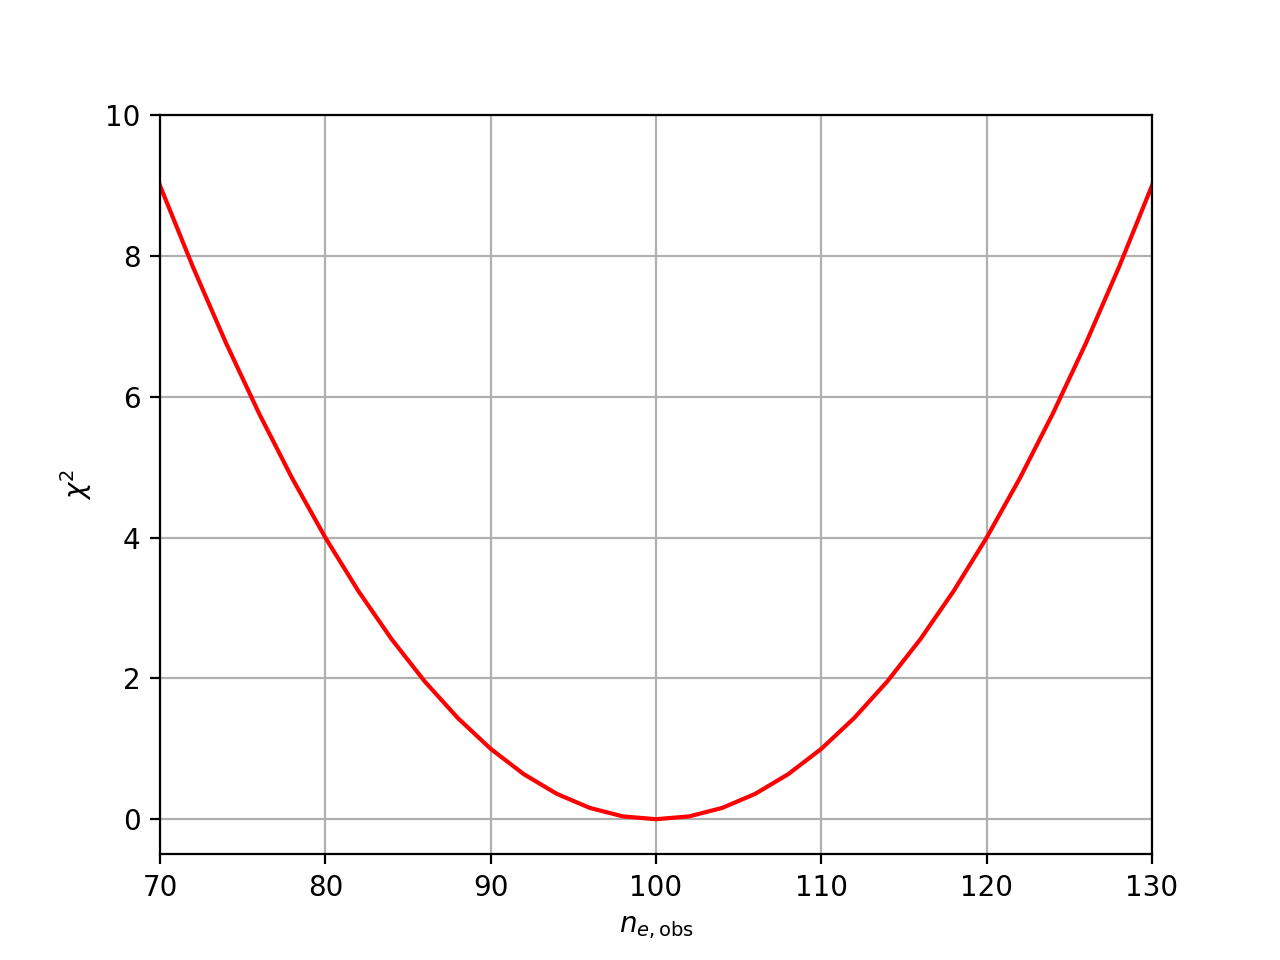

In [7]:
%matplotlib notebook

e_obs_arr = np.arange(50,150,2.0)
chi2_arr = chi2(e_obs=e_obs_arr,mu_obs=10000,**config)

fig,ax = plt.subplots()

ax.plot(e_obs_arr,chi2_arr,"r-")
ax.set_ylabel('$\chi^2$')

ax.set_xlabel('$n_{e,\mathregular{obs}}$')
ax.set_ylim(-0.5,10.0)
ax.set_xlim(70,130)
ax.grid(True)
plt.show()

## The Constraint In Action

The above showed the $\chi^2$ as a function of observed number of electrons, but in a setup where there were only statistical uncertainties. Let's add in some systematic uncertainties, with a perfectly correlated 10% cross section uncertainty, but no reconstruction uncertainties.

In [8]:
config = { 'mu_exp': 10000,
           'e_exp': 100,
           'mu_xsec_frac_err': 0.1,
           'mu_reco_frac_err': 0.0,
           'e_xsec_frac_err': 0.1,
           'e_reco_frac_err': 0.0,
           'xsec_corr': 1.0,
           'reco_corr': 0.0
         }
print "Covariance matrix:\n%s" % mcov_total(**config)

Covariance matrix:
[[2.00e+02 1.00e+04]
 [1.00e+04 1.01e+06]]


Now, we can plot the $\chi^2$ as a function of the number of observed electron events ($n_{e,\texttt{obs}}$), but it will be different as we vary the number of observed muon events ($n_{\mu,\texttt{obs}}$) due to the correlation in the cross section uncertainty. If we observe fewer muon events than expected, then it suggests the cross section may be lower than expected (or, certainly it leans against the cross section being much higher than expected). The minimum in the $\chi^2(n_{e,\texttt{obs}})$ will shift lower: in fact, it will move to $90$, mirroring the $10\%$ shift downward on the muon side.

<IPython.core.display.Javascript object>


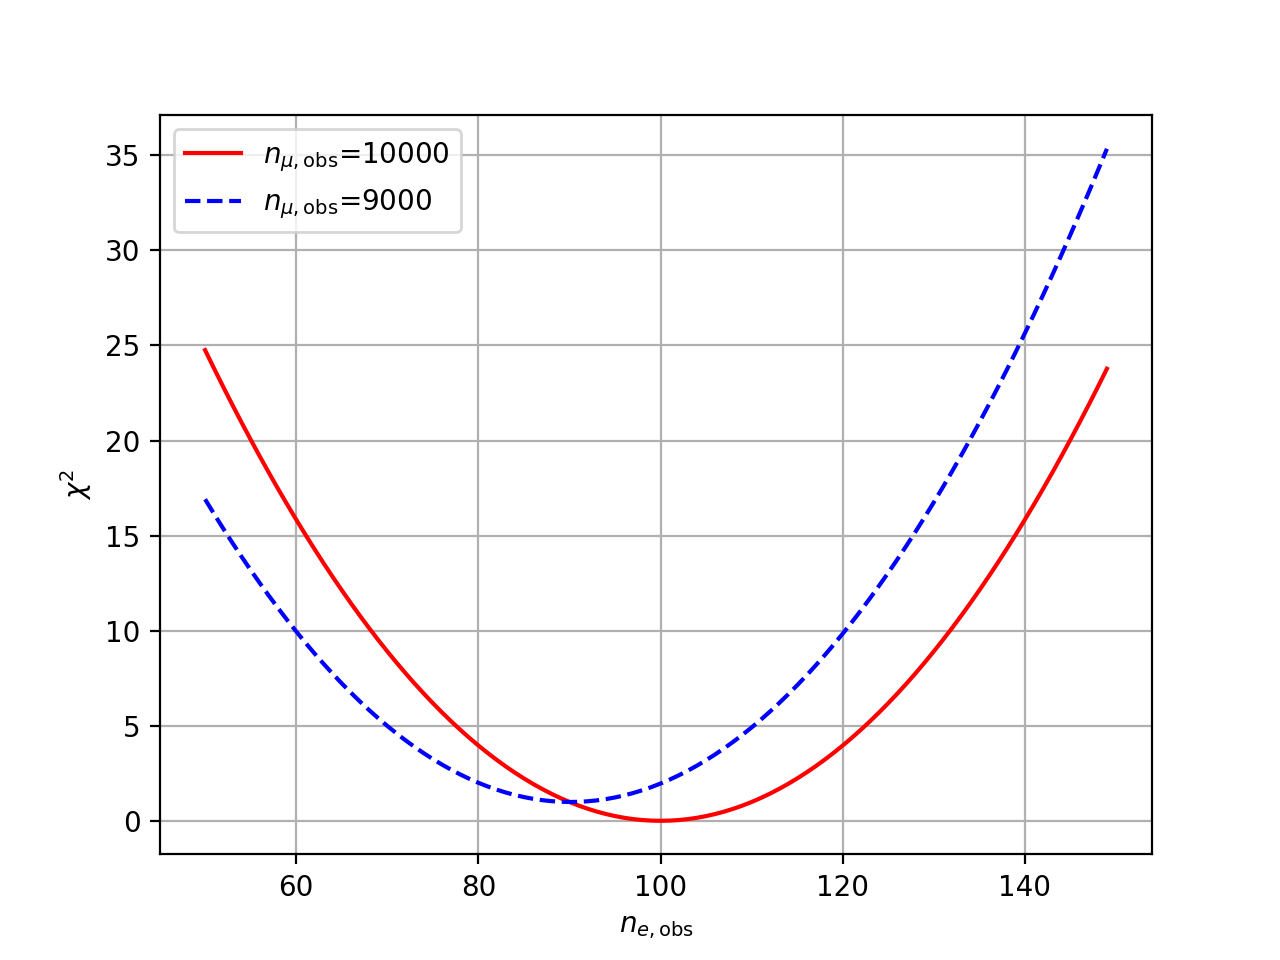

In [9]:
e_obs_arr = np.arange(50,150,1.0)
chi2_mu_obs_10000 = chi2(e_obs=e_obs_arr,mu_obs=10000,**config)
chi2_mu_obs_9000 = chi2(e_obs=e_obs_arr,mu_obs=9000,**config)

fig,ax = plt.subplots()

ax.plot(e_obs_arr,chi2_mu_obs_10000,"r-",label='$n_{\mu,\mathregular{obs}}$=10000')
ax.plot(e_obs_arr,chi2_mu_obs_9000,"b--",label='$n_{\mu,\mathregular{obs}}$=9000')
ax.set_ylabel('$\chi^2$')
ax.set_xlabel('$n_{e,\mathregular{obs}}$')
ax.grid(True)
plt.legend()
plt.show()

It's more fun if we can make that interactive: watch how the $\chi^2$ curve changes as we modify the observed number of muon events:

<IPython.core.display.Javascript object>


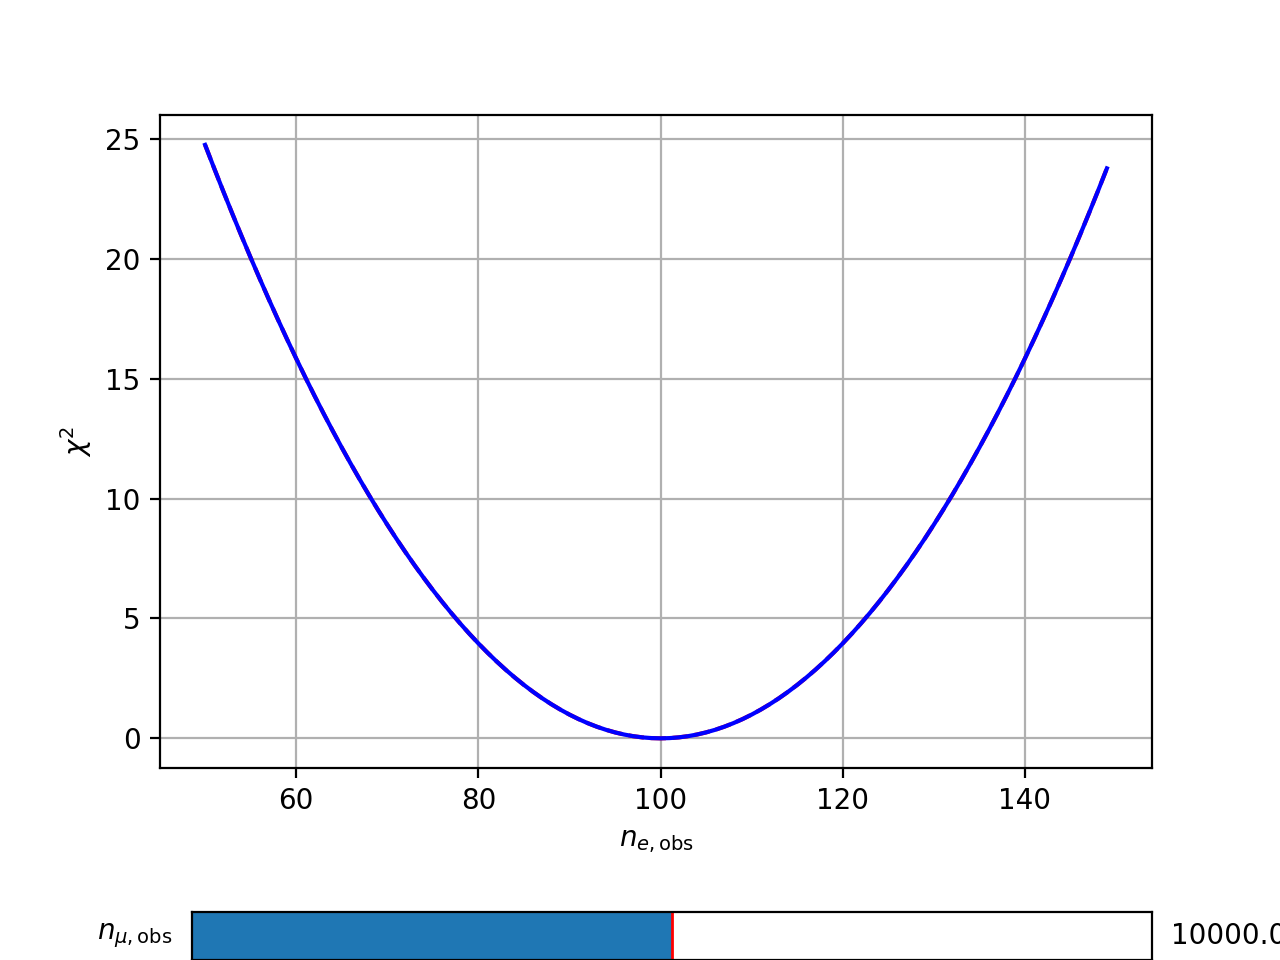

In [10]:
e_obs_arr = np.arange(50,150,1.0)

fig,ax = plt.subplots()
plt.subplots_adjust(bottom=0.2)

ax.plot(e_obs_arr,chi2(e_obs=e_obs_arr,mu_obs=10000,**config),"r--")
sline, = ax.plot(e_obs_arr,chi2(e_obs=e_obs_arr,mu_obs=10000,**config),"b-")

ax.set_ylabel('$\chi^2$')
ax.set_xlabel('$n_{e,\mathregular{obs}}$')
ax.grid(True)

ax_mu_obs = plt.axes([0.15, 0., 0.75, 0.05])
s_mu_obs = Slider(ax_mu_obs, '$n_{\mu,\mathregular{obs}}$', 7000, 13000, valinit=10000, valstep=100)

def update(val):
    this_mu_obs = s_mu_obs.val
    sline.set_ydata(chi2(e_obs=e_obs_arr,mu_obs=this_mu_obs,**config))
    fig.canvas.draw_idle()
s_mu_obs.on_changed(update)

plt.show()

There's two things worth pointing out:

1. Again, the minimum of the $\chi^2$ follows the direction of the observed number of muons, which is really rather cool.


2. The $\chi^2$ only reaches zero in the case where $(n_{\mu,\texttt{obs}},n_{e,\texttt{obs}})=(10000,100)$, since that was our expectation. If $n_{\mu,\texttt{obs}}$ moves, the minimum of the $\chi^2$ as a function of $n_{e,\texttt{obs}}$ will not reach $0.$ because we are still discrepant from our prior expectation.


Is that latter point a problem? No, not really: the $\chi^2$ here is not conditional. In fact, it's an accurate reflection given our input expectations and uncertainties on those, and it properly adjusts relative expectations between channels based on our input correlations.

Consider: if we measured the muons to be $30\%$ low, certainly we would also expect to measure the electrons $30\%$ lower as well. But, such a low measurement would be well outside our input uncertainty of $10\%$, and so is, truly unlikely. It would certainly be more unlikely to not also measure the electron events to be $30\%$ lower! But it's not quite fair to say that $30\%$ fewer electron events would be a good fit: it's likely there is something wrong with the underling model and/or the uncertainties on it.

To illustrate that a little bit more, let's see how the $\chi^2$ varies if we also vary the cross section uncertainty. In the above example we had an uncertainty of $10\%$, and one can see the (vertical) shift away from a minimum $\chi^2=0.0$. The smaller that uncertainty, the more dramatic that shift, while the larger the uncertainty is, the more we can "absorb" the difference, and we don't take such a large penalty on the $\chi^2$ if we observe something larger or smaller than expected.

<IPython.core.display.Javascript object>


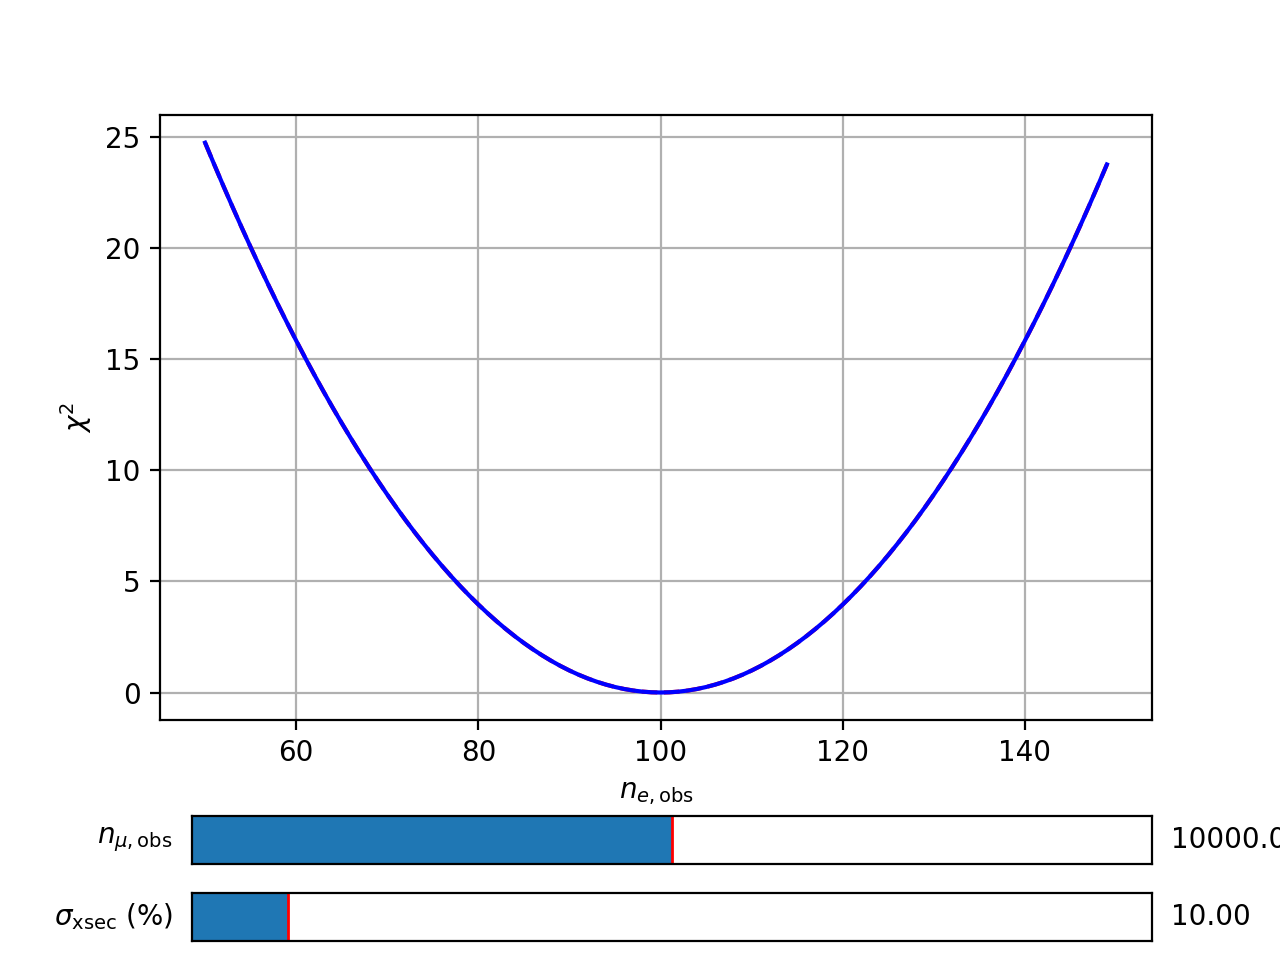

In [11]:
config_a = { 'mu_exp': 10000,
             'e_exp': 100,
             #'mu_xsec_frac_err': 0.1, #we will vary this
             'mu_reco_frac_err': 0.0,
             #'e_xsec_frac_err': 0.1,  #we will vary this
             'e_reco_frac_err': 0.0,
             'xsec_corr': 1.0,
             'reco_corr': 0.0
           }

e_obs_arr = np.arange(50,150,1.0)

fig,ax = plt.subplots()
plt.subplots_adjust(bottom=0.25)

ax.plot(e_obs_arr,chi2(e_obs=e_obs_arr,mu_obs=10000,mu_xsec_frac_err=0.1,e_xsec_frac_err=0.1,**config_a),"r--")
sline, = ax.plot(e_obs_arr,chi2(e_obs=e_obs_arr,mu_obs=10000,mu_xsec_frac_err=0.1,e_xsec_frac_err=0.1,**config_a),"b-")

ax.set_ylabel('$\chi^2$')
ax.set_xlabel('$n_{e,\mathregular{obs}}$')
ax.grid(True)

ax_mu_obs = plt.axes([0.15, 0.1, 0.75, 0.05])
ax_xsec_err = plt.axes([0.15, 0.02, 0.75, 0.05])
s_mu_obs = Slider(ax_mu_obs, '$n_{\mu,\mathregular{obs}}$', 7000, 13000, valinit=10000, valstep=100)
s_xsec_err = Slider(ax_xsec_err, '$\sigma_{\mathregular{xsec}}$ (%)', 0.0, 100, valinit=10, valstep=1)

def update(val):
    this_mu_obs = s_mu_obs.val
    this_xsec_err = 0.01*s_xsec_err.val
    sline.set_ydata(chi2(e_obs=e_obs_arr,mu_obs=this_mu_obs,mu_xsec_frac_err=this_xsec_err,e_xsec_frac_err=this_xsec_err,**config_a))
    fig.canvas.draw_idle()
s_mu_obs.on_changed(update)
s_xsec_err.on_changed(update)

plt.show()

In the above, if you place the cross section uncertainty at $50\%$, the $\chi^2$ appears to hit very near to $0.0$ for $(n_{\mu,\texttt{obs}},n_{e,\texttt{obs}})=(8000,80)$. We can see that more directly:

In [12]:
chi2_10 = chi2(e_obs=80,mu_obs=8000,mu_xsec_frac_err=0.1,e_xsec_frac_err=0.1,**config_a)
chi2_50 = chi2(e_obs=80,mu_obs=8000,mu_xsec_frac_err=0.5,e_xsec_frac_err=0.5,**config_a)

print "chi2(xsec_err=10%%)=%f" % chi2_10
print "chi2(xsec_err=50%%)=%f" % chi2_50

chi2(xsec_err=10%)=3.960784
chi2(xsec_err=50%)=0.159937


We can inspect that a little bit more by looking at the covariance matrix and its inverse for the two cases ($\sigma_{\texttt{XSEC}}=10\%$ or $=50\%$):

In [13]:
mcov_10 = mcov_total(mu_xsec_frac_err=0.1,e_xsec_frac_err=0.1,**config_a)
mcov_50 = mcov_total(mu_xsec_frac_err=0.5,e_xsec_frac_err=0.5,**config_a)

print mcov_10
print np.linalg.inv(mcov_10)
print "\n\n"
print mcov_50
print np.linalg.inv(mcov_50)


[[2.00e+02 1.00e+04]
 [1.00e+04 1.01e+06]]
[[ 9.90196078e-03 -9.80392157e-05]
 [-9.80392157e-05  1.96078431e-06]]



[[2.600e+03 2.500e+05]
 [2.500e+05 2.501e+07]]
[[ 9.90102930e-03 -9.89707047e-05]
 [-9.89707047e-05  1.02929533e-06]]


One last thing we can do here is to see how things are modified if we adjust the degree of correlation between the muon and electron channels. Playing with the plot below, we can see that it's no longer true that the cross section uncertainty can be varied to practically unconstrained values and still achieve a reasonable $\chi^2$: the muon channel is only partially constraining the electrons, and the part that is left without the constraint will contribute a large systematic uncertainty. Even small degrees of uncorrelated behavior can leave large residual uncertianties!

<IPython.core.display.Javascript object>


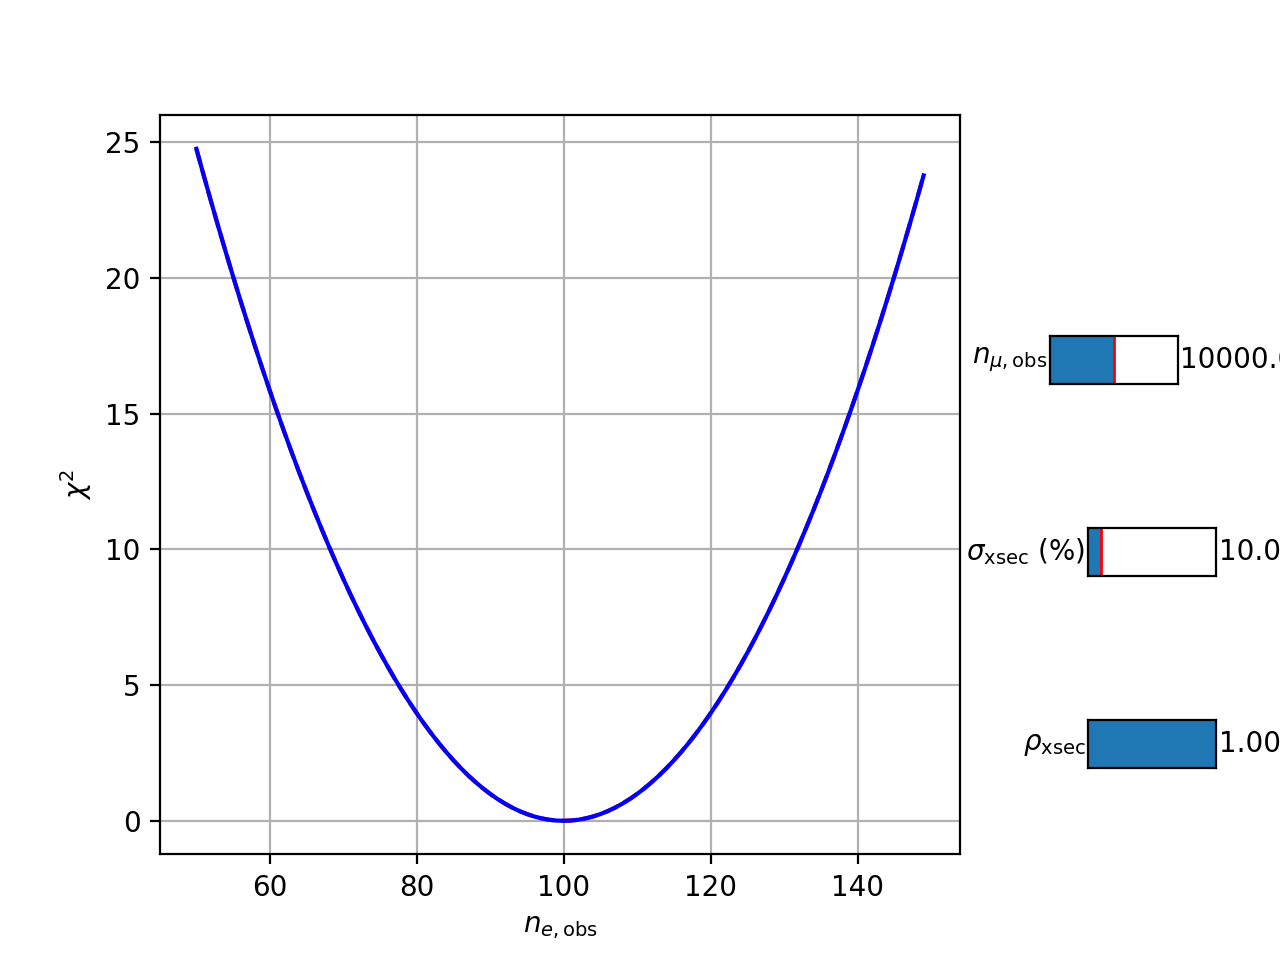

In [14]:
config_a = { 'mu_exp': 10000,
             'e_exp': 100,
             #'mu_xsec_frac_err': 0.1, #we will vary this
             'mu_reco_frac_err': 0.0,
             #'e_xsec_frac_err': 0.1,  #we will vary this
             'e_reco_frac_err': 0.0,
             #'xsec_corr': 1.0,        #let's vary this now too
             'reco_corr': 0.0
           }

e_obs_arr = np.arange(50,150,1.0)

fig,ax = plt.subplots()
plt.subplots_adjust(right=0.75)

ax.plot(e_obs_arr,chi2(e_obs=e_obs_arr,mu_obs=10000,mu_xsec_frac_err=0.1,e_xsec_frac_err=0.1,xsec_corr=1.0,**config_a),"r--")
sline, = ax.plot(e_obs_arr,chi2(e_obs=e_obs_arr,mu_obs=10000,mu_xsec_frac_err=0.1,e_xsec_frac_err=0.1,xsec_corr=1.0,**config_a),"b-")

ax.set_ylabel('$\chi^2$')
ax.set_xlabel('$n_{e,\mathregular{obs}}$')
ax.grid(True)

ax_mu_obs = plt.axes([0.82, 0.6, 0.1, 0.05])
ax_xsec_err = plt.axes([0.85, 0.4, 0.1, 0.05])
ax_xsec_corr = plt.axes([0.85, 0.2, 0.1, 0.05])
s_mu_obs = Slider(ax_mu_obs, '$n_{\mu,\mathregular{obs}}$', 7e3, 13e3, valinit=10e3, valstep=100)
s_xsec_err = Slider(ax_xsec_err, '$\sigma_{\mathregular{xsec}}$ (%)', 0.0, 100, valinit=10, valstep=1)
s_xsec_corr = Slider(ax_xsec_corr, '$\\rho_{\mathregular{xsec}}$', 0.0, 1.0, valinit=1.0, valstep=0.05)

def update(val):
    this_mu_obs = s_mu_obs.val
    this_xsec_err = 0.01*s_xsec_err.val
    this_xsec_corr = s_xsec_corr.val
    sline.set_ydata(chi2(e_obs=e_obs_arr,mu_obs=this_mu_obs,mu_xsec_frac_err=this_xsec_err,e_xsec_frac_err=this_xsec_err,xsec_corr=this_xsec_corr,**config_a))
    fig.canvas.draw_idle()
s_mu_obs.on_changed(update)
s_xsec_err.on_changed(update)
s_xsec_corr.on_changed(update)

plt.show()

## The Constraint Under Attack

The above showed the $\chi^2$ as a function of observed number of electrons, where we had a systematic error that was shared between our two channels. Now let's add in an additional 'reconstruction' systematic uncertainty for the muon channel (10%) that's not shared or corellated with the electron channel.

In [15]:
config = { 'mu_exp': 10000,
           'e_exp': 100,
           'mu_xsec_frac_err': 0.1,
           'mu_reco_frac_err': 0.1,
           'e_xsec_frac_err': 0.1,
           'e_reco_frac_err': 0.0,
           'xsec_corr': 1.0,
           'reco_corr': 0.0
         }
print "Covariance matrix:\n%s" % mcov_total(**config)

Covariance matrix:
[[2.00e+02 1.00e+04]
 [1.00e+04 2.01e+06]]


As we did before, we can plot the $\chi^2$ as a function of the number of observed electron events ($n_{e,\texttt{obs}}$), and it will again change as we vary the number of observed muon events ($n_{\mu,\texttt{obs}}$) due to the correlation in the cross section uncertainty. But, the presence of another explanation for a shift in the number of observed muons (the 'reconstruction' uncertainty) will keep the most probable number of electron events (the location of the minimum $\chi^2$) from perfectly mirroring the muons.

Let's compare the two cases for $n_{\mu,\texttt{obs}}=9000$, with and without that reconstruction uncertainty.

<IPython.core.display.Javascript object>


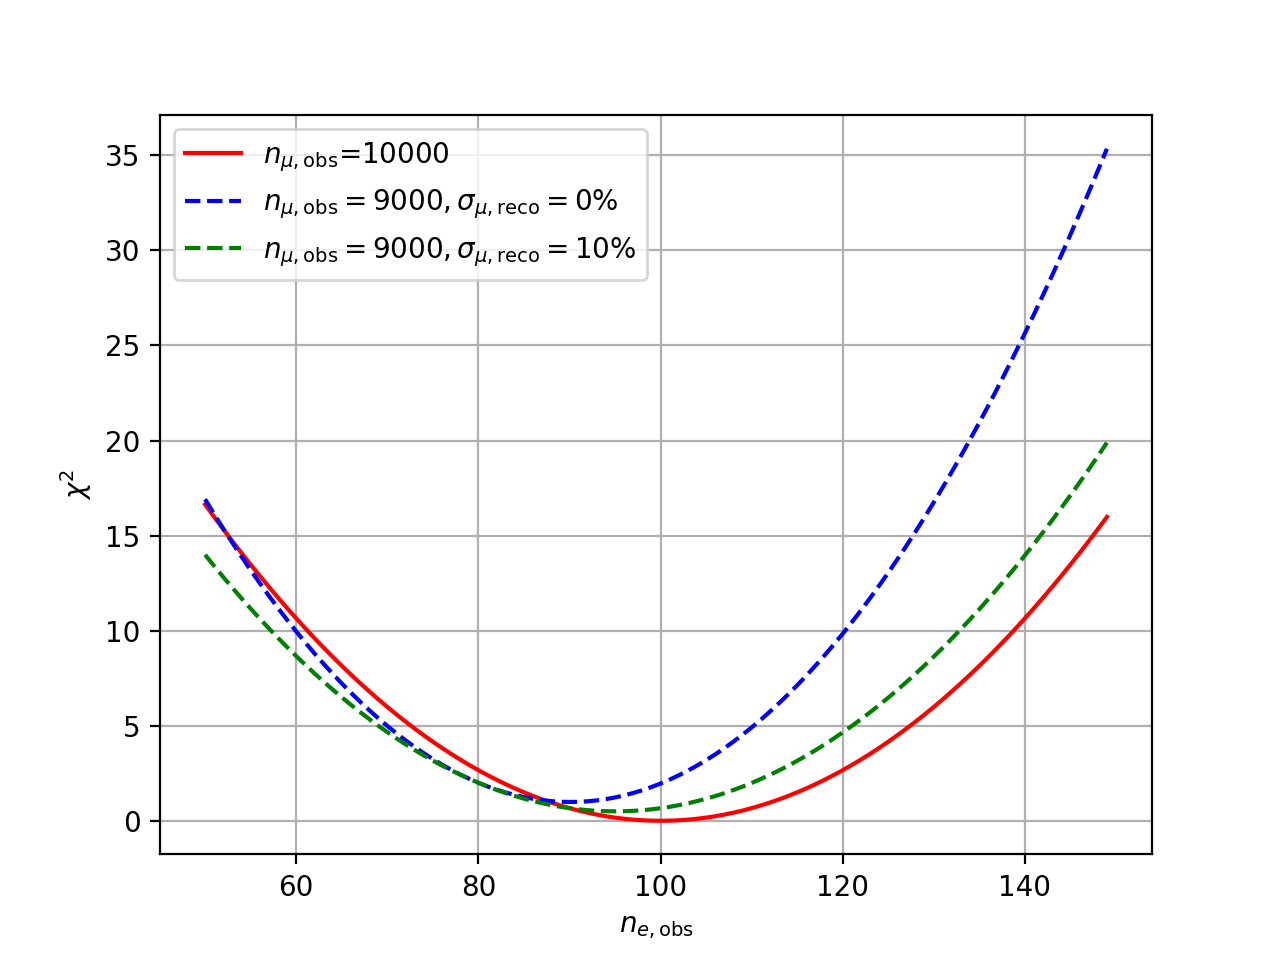

In [16]:
e_obs_arr = np.arange(50,150,1.0)
config_no_reco_err = config.copy(); config_no_reco_err['mu_reco_frac_err']=0.0
chi2_mu_obs_10000 = chi2(e_obs=e_obs_arr,mu_obs=10000,**config)
chi2_mu_obs_9000_noreco = chi2(e_obs=e_obs_arr,mu_obs=9000,**config_no_reco_err)
chi2_mu_obs_9000 = chi2(e_obs=e_obs_arr,mu_obs=9000,**config)

fig,ax = plt.subplots()

ax.plot(e_obs_arr,chi2_mu_obs_10000,"r-",label='$n_{\mu,\mathregular{obs}}$=10000')
ax.plot(e_obs_arr,chi2_mu_obs_9000_noreco,"b--",label='$n_{\mu,\mathregular{obs}}=9000,\sigma_{\mu,\mathregular{reco}}=0\%$')
ax.plot(e_obs_arr,chi2_mu_obs_9000,"g--",label='$n_{\mu,\mathregular{obs}}=9000,\sigma_{\mu,\mathregular{reco}}=10\%$')
ax.set_ylabel('$\chi^2$')
ax.set_xlabel('$n_{e,\mathregular{obs}}$')
ax.grid(True)
plt.legend()
plt.show()


We can explicitly find where the minimum value is:

In [17]:
print "Location of minimum for n_mu,obs=9000, sigma_mu,reco=0%%: %2.1f" % e_obs_arr[np.argmin(chi2_mu_obs_9000_noreco)]
print "Location of minimum for n_mu,obs=9000, sigma_mu,reco=10%%: %2.1f" % e_obs_arr[np.argmin(chi2_mu_obs_9000)]

Location of minimum for n_mu,obs=9000, sigma_mu,reco=0%: 90.0
Location of minimum for n_mu,obs=9000, sigma_mu,reco=10%: 95.0


This makes sense: we should expect to see the expectation for the number observed electron events to shift down, but not by as much since it's possible that the reconstruction systematic could account for the shift. We can play with varying all these parameters at the same time...

<IPython.core.display.Javascript object>


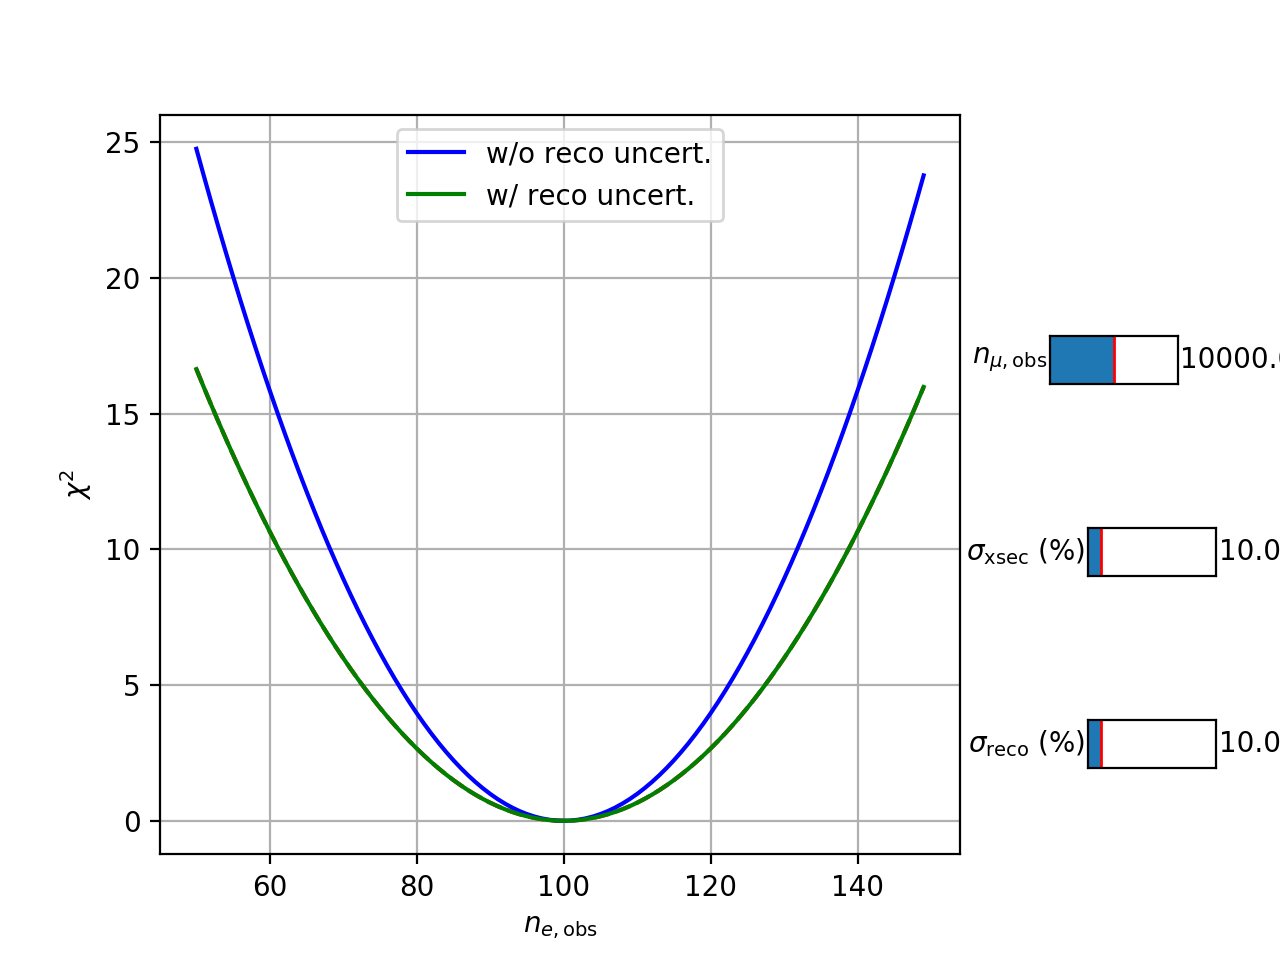

In [18]:
config_b = { 'mu_exp': 10000,
             'e_exp': 100,
             #'mu_xsec_frac_err': 0.1, #we will vary this
             #'mu_reco_frac_err': 0.0,  #let's vary this now too
             #'e_xsec_frac_err': 0.1,  #we will vary this
             'e_reco_frac_err': 0.0,
             'xsec_corr': 1.0,        
             'reco_corr': 0.0
           }

e_obs_arr = np.arange(50,150,1.0)

fig,ax = plt.subplots()
plt.subplots_adjust(right=0.75)

ax.plot(e_obs_arr,chi2(e_obs=e_obs_arr,mu_obs=10000,mu_xsec_frac_err=0.1,e_xsec_frac_err=0.1,mu_reco_frac_err=0.1,**config_b),"r--")
sline0, = ax.plot(e_obs_arr,chi2(e_obs=e_obs_arr,mu_obs=10000,mu_xsec_frac_err=0.1,e_xsec_frac_err=0.1,mu_reco_frac_err=0.0,**config_b),"b-",label='w/o reco uncert.')
sline, = ax.plot(e_obs_arr,chi2(e_obs=e_obs_arr,mu_obs=10000,mu_xsec_frac_err=0.1,e_xsec_frac_err=0.1,mu_reco_frac_err=0.1,**config_b),"g-",label='w/ reco uncert.')

ax.set_ylabel('$\chi^2$')
ax.set_xlabel('$n_{e,\mathregular{obs}}$')
ax.grid(True)

plt.legend()

ax_mu_obs = plt.axes([0.82, 0.6, 0.1, 0.05])
ax_xsec_err = plt.axes([0.85, 0.4, 0.1, 0.05])
ax_reco_err = plt.axes([0.85, 0.2, 0.1, 0.05])
s_mu_obs = Slider(ax_mu_obs, '$n_{\mu,\mathregular{obs}}$', 7e3, 13e3, valinit=10e3, valstep=100)
s_xsec_err = Slider(ax_xsec_err, '$\sigma_{\mathregular{xsec}}$ (%)', 0.0, 100, valinit=10, valstep=1)
s_reco_err = Slider(ax_reco_err, '$\sigma_{\mathregular{reco}}$ (%)', 0.0, 100, valinit=10, valstep=1)

def update(val):
    this_mu_obs = s_mu_obs.val
    this_xsec_err = 0.01*s_xsec_err.val
    this_reco_err = 0.01*s_reco_err.val
    sline0.set_ydata(chi2(e_obs=e_obs_arr,mu_obs=this_mu_obs,mu_xsec_frac_err=this_xsec_err,e_xsec_frac_err=this_xsec_err,mu_reco_frac_err=0.0,**config_b))
    sline.set_ydata(chi2(e_obs=e_obs_arr,mu_obs=this_mu_obs,mu_xsec_frac_err=this_xsec_err,e_xsec_frac_err=this_xsec_err,mu_reco_frac_err=this_reco_err,**config_b))
    fig.canvas.draw_idle()
s_mu_obs.on_changed(update)
s_xsec_err.on_changed(update)
s_reco_err.on_changed(update)

plt.show()

### To 'Tune', or Not to 'Tune'

One question we can ask: should we 'tune' our model if we measure a difference from the number of expected events in the muon channel. Say we measure 9,000 events when we expected 10,000: does that mean we should adjust our expectation for the number of electron events we expect to observe?

As we've seen from the above, the minimum of the $\chi^2$ will change its location based on the number of observed muon events. So, without doing anything, given the fact we observe fewer muon events than expected, we expect to see fewer electron events than originally expected. But, trying to 'tune' the model in this way can be difficult if we have to take into account additional uncertainties and correlations, and it's dangerous to do it incorrectly.

To see that, let's consider the exact scenario above: $n_{\mu,\texttt{obs}} / n_{\mu,\texttt{exp}}=9000 / 10000=0.9$, with 10% uncertainties on the cross section (in both electron and muon channels, and perfectly corellated), and a 10% reconstruction uncertainty on the muons only. Then, under a perhaps naive tuning, the $\chi^2$ for these two cases will look like this:

<IPython.core.display.Javascript object>


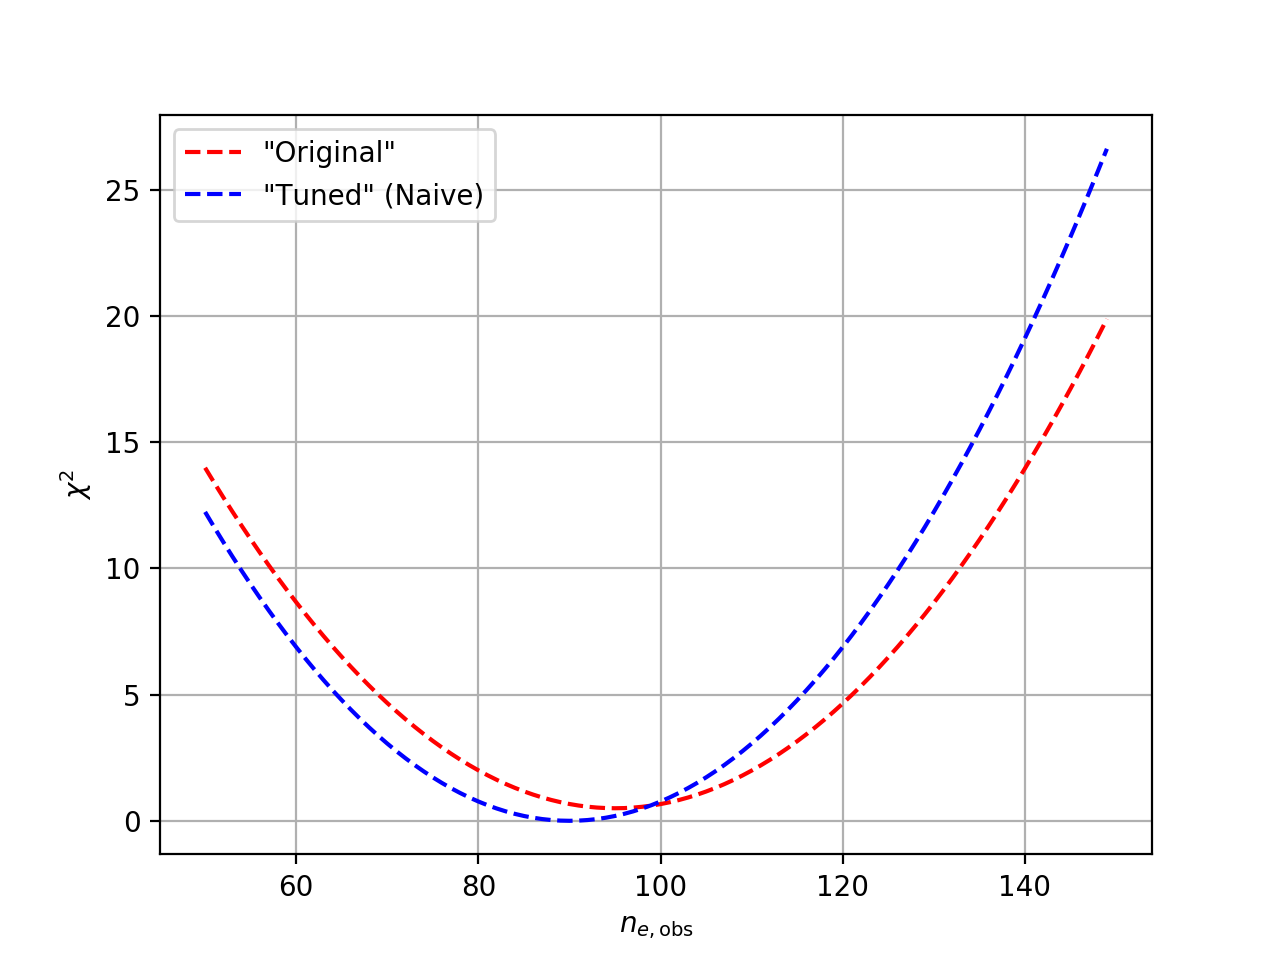

In [19]:
config = { 'mu_exp': 10000.,
           'e_exp': 100.,
           'mu_xsec_frac_err': 0.1,
           'mu_reco_frac_err': 0.1,
           'e_xsec_frac_err': 0.1,
           'e_reco_frac_err': 0.0,
           'xsec_corr': 1.0,
           'reco_corr': 0.0,
           'mu_obs': 9000.
         }

config_tune = { 'mu_exp': config['mu_obs'],
                'e_exp': (config['mu_obs']/config['mu_exp'])*config['e_exp'],
                'mu_xsec_frac_err': 0.1,
                'mu_reco_frac_err': 0.1,
                'e_xsec_frac_err': 0.1,
                'e_reco_frac_err': 0.0,
                'xsec_corr': 1.0,
                'reco_corr': 0.0,
                'mu_obs': config['mu_obs']
              }

e_obs_arr = np.arange(50,150,1.0)
chi2_orig = chi2(e_obs=e_obs_arr,**config)
chi2_tune = chi2(e_obs=e_obs_arr,**config_tune)

fig,ax = plt.subplots()

ax.plot(e_obs_arr,chi2_orig,"r--",label='"Original"')
ax.plot(e_obs_arr,chi2_tune,"b--",label='"Tuned" (Naive)')
ax.set_ylabel('$\chi^2$')
ax.set_xlabel('$n_{e,\mathregular{obs}}$')
ax.grid(True)
plt.legend()
plt.show()


A few remarks:

* In the 'original' case, the $\chi^2$ is as described before: the expected number of electron events shifts down, but not by the same amount as the number of muon events, due to the additional reconstruction uncertainty.

* Meanwhile, in the naively 'tuned' case, the $\chi^2$ hits a minimum where we have told it to: at 90 electron events.

* That downward bias is preserved across most of the $n_{e,\texttt{obs}}$ space, which means if we were to measure more electron events, it's likely we would overestimate the $\chi^2$ in our naive tuning, which could translate to a greater likelihood to declare a result anomalous.

We can investigate this for other scenarios of $n_{\mu,\texttt{obs}}$:

<IPython.core.display.Javascript object>


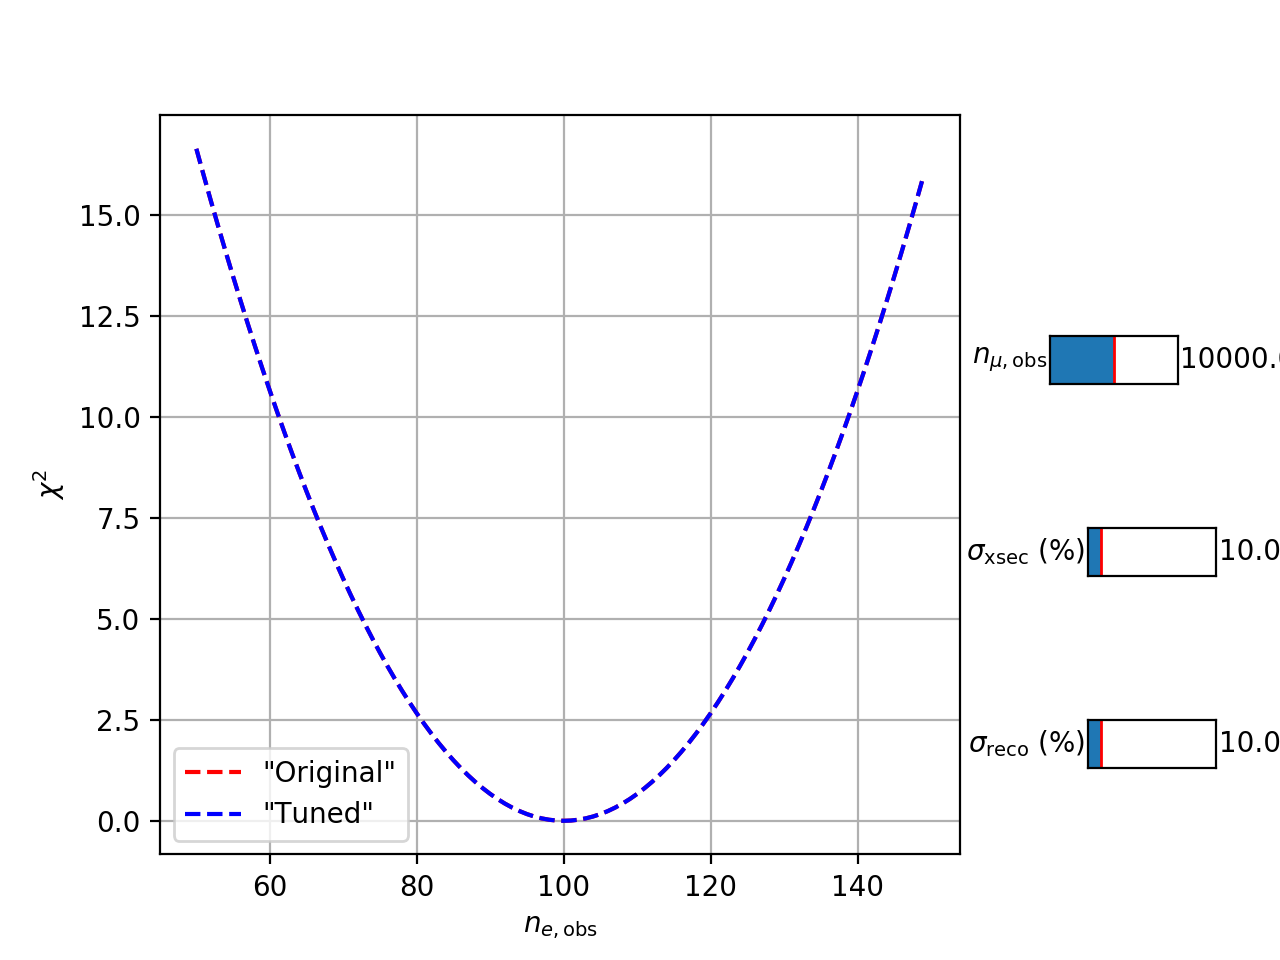

In [20]:
config_c = { 'mu_exp': 10000.,
             'e_exp': 100.,
             #'mu_xsec_frac_err': 0.1, #we will vary this
             #'mu_reco_frac_err': 0.0,  #let's vary this now too
             #'e_xsec_frac_err': 0.1,  #we will vary this
             'e_reco_frac_err': 0.0,
             'xsec_corr': 1.0,        
             'reco_corr': 0.0
           }
config_c_tune = config_c.copy()

e_obs_arr = np.arange(50,150,1.0)

fig,ax = plt.subplots()
plt.subplots_adjust(right=0.75)

sline0, = ax.plot(e_obs_arr,chi2(e_obs=e_obs_arr,mu_obs=10000,mu_xsec_frac_err=0.1,e_xsec_frac_err=0.1,mu_reco_frac_err=0.1,**config_c),"r--",label='"Original"')
sline, = ax.plot(e_obs_arr,chi2(e_obs=e_obs_arr,mu_obs=10000,mu_xsec_frac_err=0.1,e_xsec_frac_err=0.1,mu_reco_frac_err=0.1,**config_c_tune),"b--",label='"Tuned"')

ax.set_ylabel('$\chi^2$')
ax.set_xlabel('$n_{e,\mathregular{obs}}$')
ax.grid(True)

plt.legend()

ax_mu_obs = plt.axes([0.82, 0.6, 0.1, 0.05])
ax_xsec_err = plt.axes([0.85, 0.4, 0.1, 0.05])
ax_reco_err = plt.axes([0.85, 0.2, 0.1, 0.05])
s_mu_obs = Slider(ax_mu_obs, '$n_{\mu,\mathregular{obs}}$', 7e3, 13e3, valinit=10e3, valstep=100)
s_xsec_err = Slider(ax_xsec_err, '$\sigma_{\mathregular{xsec}}$ (%)', 0.0, 100, valinit=10, valstep=1)
s_reco_err = Slider(ax_reco_err, '$\sigma_{\mathregular{reco}}$ (%)', 0.0, 100, valinit=10, valstep=1)

def update(val):
    this_mu_obs = s_mu_obs.val
    this_xsec_err = 0.01*s_xsec_err.val
    this_reco_err = 0.01*s_reco_err.val
    config_c_tune['mu_exp']=this_mu_obs
    config_c_tune['e_exp']=config['e_exp']*(this_mu_obs/config['mu_exp'])
    sline0.set_ydata(chi2(e_obs=e_obs_arr,mu_obs=this_mu_obs,mu_xsec_frac_err=this_xsec_err,e_xsec_frac_err=this_xsec_err,mu_reco_frac_err=this_reco_err,**config_c))
    sline.set_ydata(chi2(e_obs=e_obs_arr,mu_obs=this_mu_obs,mu_xsec_frac_err=this_xsec_err,e_xsec_frac_err=this_xsec_err,mu_reco_frac_err=this_reco_err,**config_c_tune))
    fig.canvas.draw_idle()
s_mu_obs.on_changed(update)
s_xsec_err.on_changed(update)
s_reco_err.on_changed(update)

plt.show()

One thing to note: using the 'original' method here (what I would argue is the right thing to do) is not necessarily 'conservative'. If we observe more muon events than expected, the number of electron events we expect to observe will also be higher than the nominal, but not by as much as the muons shift up. Again, this is due to the additional 'reconstruction' uncertainty on the muon channel observation. The 'naively tuned' case will overestimate the $chi^2$ for smaller $n_{\mu,\texttt{obs}}$, and underestimate it for larger $n_{\mu,\texttt{obs}}$.

But ... what is the true impact on the final interpretation? We could convert all the $\chi^2$ values to p-values here, but let's do something slightly more rigorous (if computationally intensive!) and throw a bunch of pseudo-experiments.

To do that, let's (1) redefine our configurations, (2) get the systematics-only part of the covariance matrix, (3) generate new "expected" numbers of electron and muon events from random (Gaussian) throws from that covariance matrix, and then (4) generate "observed" electron and muon events from random (Poissonian) throws from those numbers.

In [21]:
config = { 'mu_exp': 10000.,
           'e_exp': 100.,
           'mu_xsec_frac_err': 0.1,
           'mu_reco_frac_err': 0.1,
           'e_xsec_frac_err': 0.1,
           'e_reco_frac_err': 0.0,
           'xsec_corr': 1.0,
           'reco_corr': 0.0,
           'mu_obs': 9000.
         }
m_cov_sys_orig = mcov_sysonly(**config)
print "Covariance matrix ('original'):"
print m_cov_sys_orig

print "\n"

config_tune = { 'mu_exp': config['mu_obs'],
                'e_exp': (config['mu_obs']/config['mu_exp'])*config['e_exp'],
                'mu_xsec_frac_err': 0.1,
                'mu_reco_frac_err': 0.1,
                'e_xsec_frac_err': 0.1,
                'e_reco_frac_err': 0.0,
                'xsec_corr': 1.0,
                'reco_corr': 0.0,
                'mu_obs': config['mu_obs']
              }
m_cov_sys_tune = mcov_sysonly(**config_tune)
print "Covariance matrix ('tuned'):"
print m_cov_sys_tune


Covariance matrix ('original'):
[[1.e+02 1.e+04]
 [1.e+04 2.e+06]]


Covariance matrix ('tuned'):
[[8.10e+01 8.10e+03]
 [8.10e+03 1.62e+06]]


In [22]:
print "10 Pseudo-experiments ('original'):"
print pd.DataFrame(np.random.poisson(np.random.multivariate_normal([config['e_exp'],config['mu_exp']],
                                                             m_cov_sys_orig,10)),
             columns=['e_obs','mu_obs'])
print "\n"
print "10 Pseudo-experiments ('tuned'):"
print pd.DataFrame(np.random.poisson(np.random.multivariate_normal([config_tune['e_exp'],config_tune['mu_exp']],
                                                             m_cov_sys_tune,10)),
             columns=['e_obs','mu_obs'])

10 Pseudo-experiments ('original'):
   e_obs  mu_obs
0     81    7551
1    112    8995
2     73    8077
3     78    8687
4     97   11504
5    103    9589
6     84   10341
7    106   13593
8    106   11231
9     99   12699


10 Pseudo-experiments ('tuned'):
   e_obs  mu_obs
0     87    9709
1     87    8811
2     59    6882
3     89    6407
4     97    8340
5    107    7931
6     81    6914
7     60    6639
8     54    5030
9    101    9391


Great! However, to do some real studies, we will need _a lot_ more than 10 pseudo-experiments. Let's run 100 million for each scenario. So we don't do this literally everytime we run the notebook, let's first check to see if there's a file with the proper name in the current directory, and if so we just read that in. If not, we generate it!

In [23]:
hdf5_filename = "toycov_pseudoexps_1e8.hdf5"
df_orig = pd.DataFrame()
df_tune = pd.DataFrame()
if not os.path.isfile(hdf5_filename):
    n_pes = int(1e8)
    print "File doesn't exist! Will generate file named %s with %d pseudo-experiments!" % (hdf5_filename,n_pes)
    df_orig = pd.DataFrame(np.random.poisson(np.random.multivariate_normal([config['e_exp'],config['mu_exp']],
                                                                           m_cov_sys_orig,n_pes)),
                           columns=['e_obs','mu_obs'])
    df_orig.to_hdf(hdf5_filename,"orig",mode="a")
    df_tune = pd.DataFrame(np.random.poisson(np.random.multivariate_normal([config_tune['e_exp'],config_tune['mu_exp']],
                                                                           m_cov_sys_tune,n_pes)),
                           columns=['e_obs','mu_obs'])
    df_tune.to_hdf(hdf5_filename,"tune",mode="a")
else:
    print "File %s exists! Reading it up." % hdf5_filename
    df_orig = pd.read_hdf(hdf5_filename,"orig")
    df_tune = pd.read_hdf(hdf5_filename,"tune")

File toycov_pseudoexps_1e8.hdf5 exists! Reading it up.


That done, we can just plot the results of all the pseudo-experiments we've made (or, that can take a while ... maybe let's just plot the first 100,000).

<IPython.core.display.Javascript object>


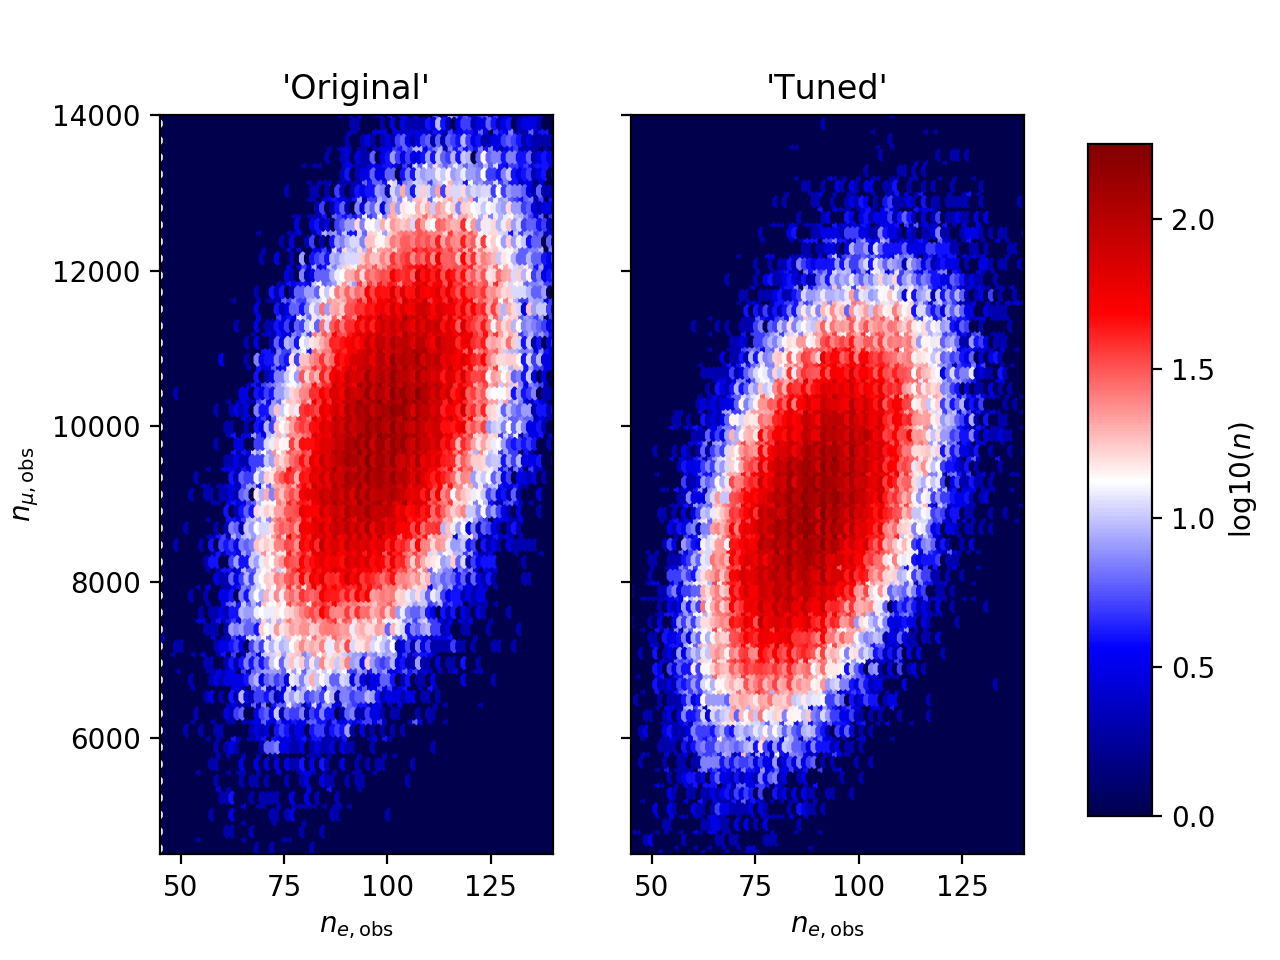

In [24]:
n_toplot = int(1e5)
f, (ax1, ax2) = plt.subplots(1, 2, sharex=True, sharey=True)
hb1 = ax1.hexbin(x=df_orig[0:n_toplot].e_obs,y=df_orig[0:n_toplot].mu_obs,bins='log',cmap='seismic')
hb2 = ax2.hexbin(x=df_tune[0:n_toplot].e_obs,y=df_tune[0:n_toplot].mu_obs,bins='log',cmap='seismic')
ax1.set_ylim([4500,14000])
ax1.set_xlim([45,140])
ax1.set_title("'Original'")
ax2.set_title("'Tuned'")
ax1.set_ylabel("$n_{\mu,\mathregular{obs}}$")
ax1.set_xlabel("$n_{e,\mathregular{obs}}$")
ax2.set_xlabel("$n_{e,\mathregular{obs}}$")
f.subplots_adjust(right=0.8)
cbar_ax = f.add_axes([0.85, 0.15, 0.05, 0.7])
cb = f.colorbar(hb2,cax=cbar_ax)
cb.set_label('log10($n$)')
plt.show()

So, now: we want to compare the two situations where we have the same number of observed events in the muon channel. Let's pick $n_{\mu,\texttt{obs}}=9000$ again, and create filtered datasets that match that.

(Note, let's set up a small tolerance around $n_{\mu,\texttt{obs}}=9000$ so we can bump up our stats a little bit.)

In [25]:
my_mu_obs=9000; tolerance=10
f_query='mu_obs>(%d-%d) and mu_obs<(%d+%d)' % (my_mu_obs,tolerance,my_mu_obs,tolerance)
df_orig_f = df_orig.query(f_query)
df_tune_f = df_tune.query(f_query)

Not surprisingly, we can find pretty quickly these are rather different. As we discovered before, the mean of the 'original' distribution is around 95 events, while the mean of the 'tuned' one has been tuned to be 90 events. The variances are also a bit different.

In [26]:
print "Original (mu_obs=9000): Mean=%f, Variance=%f" % (df_orig_f.e_obs.mean(),df_orig_f.e_obs.var())
print "Tuned    (mu_obs=9000): Mean=%f, Variance=%f" % (df_tune_f.e_obs.mean(),df_tune_f.e_obs.var())

Original (mu_obs=9000): Mean=95.050052, Variance=145.020530
Tuned    (mu_obs=9000): Mean=90.025183, Variance=130.950758


<IPython.core.display.Javascript object>


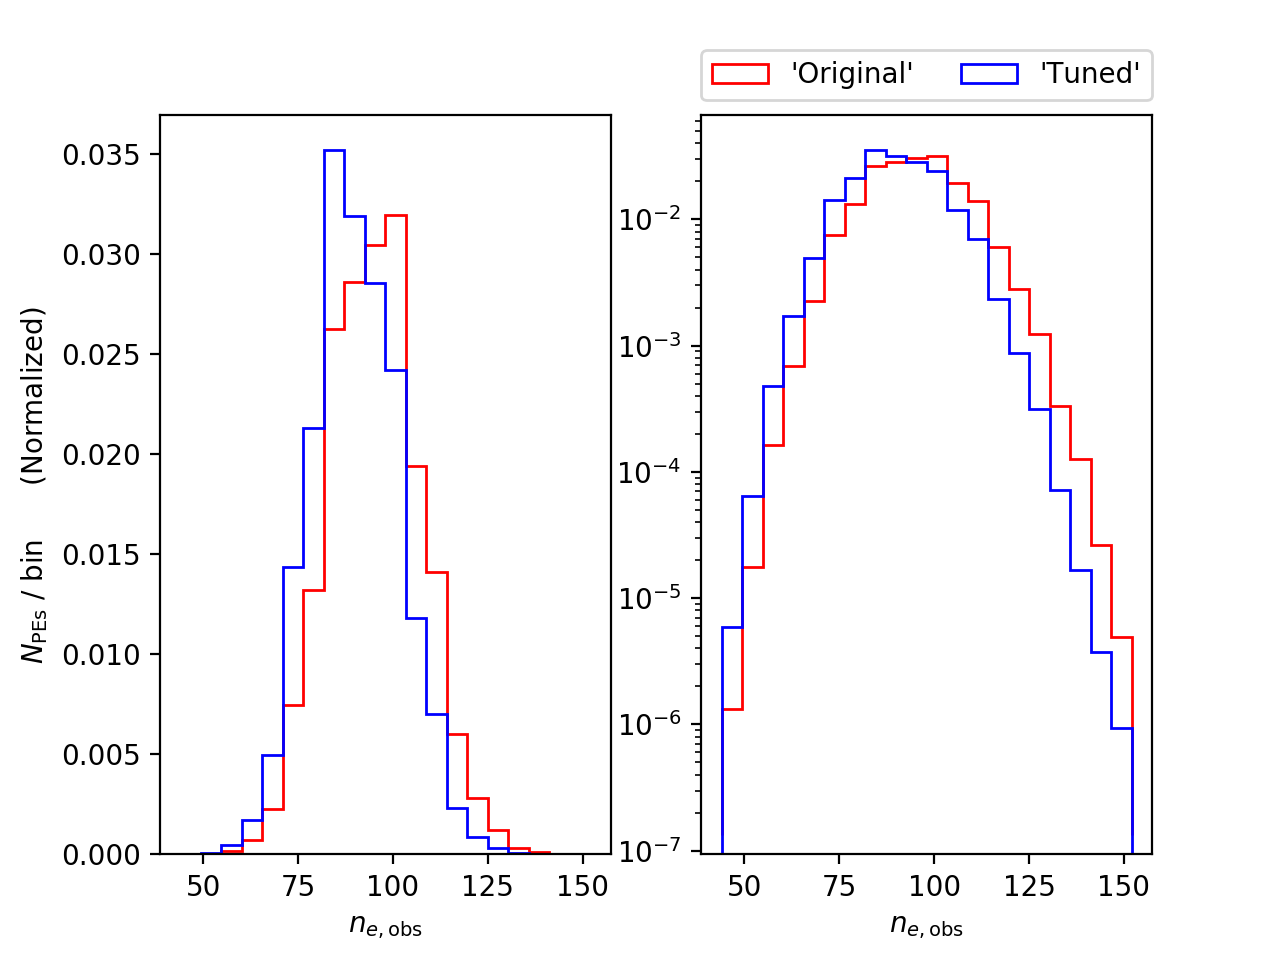

In [27]:
fig, (ax,lax) = plt.subplots(1,2,sharex=True)
n_orig_lin, bins, patches = ax.hist(df_orig_f.e_obs,20,color='r',label="'Original'",histtype="step",density=True)
n_tune_lin, bins, patchers  = ax.hist(df_tune_f.e_obs,bins,color='b',label="'Tuned'",histtype="step",density=True)
lax.hist(df_orig_f.e_obs,bins,color='r',label="'Original'",histtype="step",density=True,log=True)
lax.hist(df_tune_f.e_obs,bins,color='b',label="'Tuned'",histtype="step",density=True,log=True)
ax.set_ylabel("$N_\mathregular{PEs}$ / bin \t (Normalized)")
ax.set_xlabel("$n_{e,\mathregular{obs}}$")
lax.set_xlabel("$n_{e,\mathregular{obs}}$")
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0.)
plt.show()

As expected from looking at the $\chi^2$ distribution, the 'tuned' case underestimates the likelihood of high $n_{e,\texttt{obs}}$ given a lower $n_{\mu,\texttt{obs}}$ than originally expected if there is an additional/uncorrelated uncertainty on only the muon channel.